In [1]:
import os

import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
import optax
import xarray as xr

from jaxparrow.tools import compute_coriolis_factor, compute_spatial_step
from jaxparrow import cyclogeostrophy, geostrophy

%reload_ext autoreload
%autoreload 2

In [2]:
# utility functions

vmin = -4
vmax = -vmin
dpi_ref = 100
full_width_px = 1600


def get_figsize(width_ratio, wh_ratio=1):
    fig_width = full_width_px / dpi_ref * width_ratio
    fig_height = fig_width / wh_ratio
    return fig_width, fig_height


from jaxparrow.tools.tools import compute_derivative, interpolate
def compute_norm_vorticity(u: np.ma.masked_array, v: np.ma.masked_array, 
                           dy_u: np.ma.masked_array, dx_v: ma.masked_array, 
                           mask: np.ndarray, f: np.ma.masked_array) -> np.ma.masked_array:
    du_dy = compute_derivative(u, dy_u, axis=0)
    du_dy = interpolate(du_dy, axis=1)
    dv_dx = compute_derivative(v, dx_v, axis=1)
    dv_dx = interpolate(dv_dx, axis=0)
    return ma.masked_array(dv_dx - du_dy, mask) / f

# Alboran sea

## Input data

In this example, we use NEMO model outputs (SSH and velocities), stored in several netCDF files.
Measurements are located on a C-grid.

Data can be downloaded [here](https://ige-meom-opendap.univ-grenoble-alpes.fr/thredds/fileServer/meomopendap/extract/MEOM/jaxparrow/alboransea.tar.gz), and the files extracted to the `data` folder.
The next cell does this for you, assuming wget and tar are available.

In [3]:
!wget -P data https://ige-meom-opendap.univ-grenoble-alpes.fr/thredds/fileServer/meomopendap/extract/MEOM/jaxparrow/alboransea.tar.gz
!tar -xzf data/alboransea.tar.gz -C data
!rm data/alboransea.tar.gz

--2023-11-24 10:25:44--  https://ige-meom-opendap.univ-grenoble-alpes.fr/thredds/fileServer/meomopendap/extract/MEOM/jaxparrow/alboransea.tar.gz
Resolving ige-meom-opendap.univ-grenoble-alpes.fr (ige-meom-opendap.univ-grenoble-alpes.fr)... 129.88.191.39
Connecting to ige-meom-opendap.univ-grenoble-alpes.fr (ige-meom-opendap.univ-grenoble-alpes.fr)|129.88.191.39|:443... connected.
HTTP request sent, awaiting response... 200 200
Length: 10021228 (9,6M) [application/octet-stream]
Saving to: ‘data/alboransea.tar.gz’

alboransea.tar.gz   100%[===================>]   9,56M  38,2MB/s    in 0,3s    

2023-11-24 10:25:44 (38,2 MB/s) - ‘data/alboransea.tar.gz’ saved [10021228/10021228]



In [4]:
data_dir = "data"
name_mask = "mask_alboransea.nc"
name_coord = "coordinates_alboransea.nc"
name_ssh = "alboransea_sossheig.nc"
name_u = "alboransea_sozocrtx.nc"
name_v = "alboransea_somecrty.nc"

In [5]:
ds_coord = xr.open_dataset(os.path.join(data_dir, name_coord))
lon = ds_coord.nav_lon.values
lat = ds_coord.nav_lat.values

ds_mask = xr.open_dataset(os.path.join(data_dir, name_mask))
mask_ssh = ds_mask.tmask[0,0].values
mask_u = ds_mask.umask[0,0].values
mask_v = ds_mask.vmask[0,0].values

ds_ssh = xr.open_dataset(os.path.join(data_dir, name_ssh))
lon_ssh = ds_ssh.nav_lon.values
lat_ssh = ds_ssh.nav_lat.values
ssh = ds_ssh.sossheig[0].values

ds_u = xr.open_dataset(os.path.join(data_dir, name_u))
lon_u = ds_u.nav_lon.values
lat_u = ds_u.nav_lat.values
uvel = ds_u.sozocrtx[0].values

ds_v = xr.open_dataset(os.path.join(data_dir, name_v))
lon_v = ds_v.nav_lon.values
lat_v = ds_v.nav_lat.values
vvel = ds_v.somecrty[0].values

We use `masked_array` to restrict the domain to the marine area.

In [6]:
mask_u = 1 - mask_u
mask_v = 1 - mask_v
mask_ssh = 1 - mask_ssh

In [7]:
uvel = ma.masked_array(uvel, mask_u)
vvel = ma.masked_array(vvel, mask_v)
ssh = ma.masked_array(ssh, mask_ssh)

In [8]:
lon_u = ma.masked_array(lon_u, mask_u)
lat_u = ma.masked_array(lat_u, mask_u)
lon_v = ma.masked_array(lon_v, mask_v)
lat_v = ma.masked_array(lat_v, mask_v)
lon_ssh = ma.masked_array(lon_ssh, mask_ssh)
lat_ssh = ma.masked_array(lat_ssh, mask_ssh)

### Compute spatial steps

The netCDF files we use as input do not contain the spatial steps required to compute derivatives later.
The sub-module `tools` provides the utility function `compute_spatial_step` to compute them from our grids. It applies Von Neuman boundary conditions to those fields.

In [9]:
dx_ssh, dy_ssh = compute_spatial_step(lat_ssh, lon_ssh)
dx_u, dy_u = compute_spatial_step(lat_u, lon_u)
dx_v, dy_v = compute_spatial_step(lat_v, lon_v)

### Coriolis factor

Estimating the velocities also involve the Coriolis factor, which varies with the latitude.
The function `compute_coriolis_factor` from the sub-module `tools` might be used here.

In [10]:
coriolis_factor = compute_coriolis_factor(lat)
coriolis_factor_u = compute_coriolis_factor(lat_u)
coriolis_factor_v = compute_coriolis_factor(lat_v)

### Visualising SSH and currents

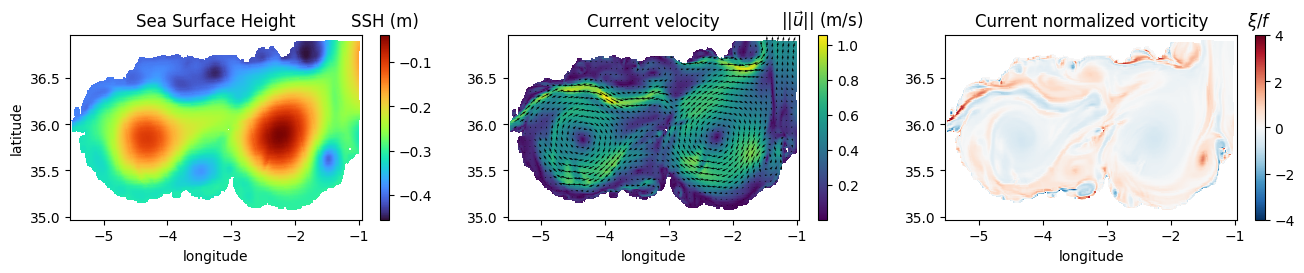

In [11]:
norm_vorticity = compute_norm_vorticity(uvel, vvel, dy_u, dx_v, mask_ssh, coriolis_factor)

_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=get_figsize(1, 20/3))

ax1.set_title("Sea Surface Height")
ax1.set_xlabel("longitude")
ax1.set_ylabel("latitude")
im = ax1.pcolormesh(lon, lat, ssh, cmap="turbo", shading="auto")
clb1 = plt.colorbar(im, ax=ax1)
clb1.ax.set_title("SSH (m)")

ax2.set_title("Current velocity")
ax2.set_xlabel("longitude")
im = ax2.pcolormesh(lon, lat, np.sqrt(uvel**2 + vvel**2), shading="auto")
ax2.quiver(lon[::5, ::5], lat[::5, ::5], uvel[::5, ::5], vvel[::5, ::5], color="k")
clb2 = plt.colorbar(im, ax=ax2)
clb2.ax.set_title("$\\vert\\vert \\vec{u} \\vert\\vert$ (m/s)")

ax3.set_title("Current normalized vorticity")
ax3.set_xlabel("longitude")
im = ax3.pcolormesh(lon, lat, norm_vorticity, cmap="RdBu_r", shading="auto", 
                    vmin=vmin, vmax=vmax)
clb3 = plt.colorbar(im, ax=ax3)
clb3.ax.set_title("$\\xi / f$")

plt.savefig("../paper/fig/ref.png", bbox_inches="tight")
plt.show()

## Geostrophic balance

We estimate the geostrophic velocities using the `geostrophy` function, given the SSH, the spatial steps, and the coriolis factors.

In [12]:
u_geos, v_geos = geostrophy(ssh, dx_ssh, dy_ssh, coriolis_factor_u, coriolis_factor_v)

u_geos = ma.masked_array(u_geos, mask_u)
v_geos = ma.masked_array(v_geos, mask_v)

norm_vorticity_geos = compute_norm_vorticity(u_geos, v_geos, dy_u, dx_v, mask_ssh, coriolis_factor)

### Comparison to NEMO's velocities

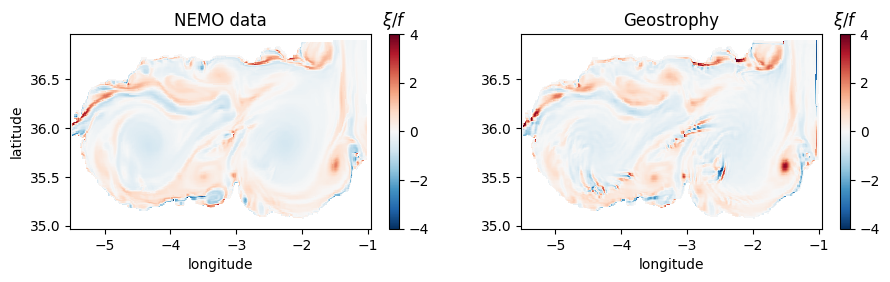

In [13]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=get_figsize(2/3, 12.66/3))

ax1.set_title("NEMO data")
ax1.set_xlabel("longitude")
ax1.set_ylabel("latitude")
im = ax1.pcolormesh(lon, lat, norm_vorticity, cmap="RdBu_r", shading="auto", 
                    vmin=vmin, vmax=vmax)
clb1 = plt.colorbar(im, ax=ax1)
clb1.ax.set_title("$\\xi / f$")

ax2.set_title("Geostrophy")
ax2.set_xlabel("longitude")
im = ax2.pcolormesh(lon, lat, norm_vorticity_geos, cmap="RdBu_r", shading="auto", 
                    vmin=vmin, vmax=vmax)
clb2 = plt.colorbar(im, ax=ax2)
clb2.ax.set_title("$\\xi / f$")

plt.savefig("../paper/fig/geostrophy.png", bbox_inches="tight")
plt.show()

## Cyclogeostrophic balance

### Variational method

Cyclogeostrophic velocities are computed via the `cyclogeostrophy` function, using geostrophic velocities (here, the ones we previously computed), spatial steps, and the coriolis factors.

The optimizer can be specified as a string (assuming it refers to an `optax` [common optimizers](https://optax.readthedocs.io/en/latest/api.html#)): `optim = "sgd"` for example.
Or designed using a more refined strategy:

In [14]:
lr_scheduler = optax.exponential_decay(1e-2, 200, .5)
base_optim = optax.sgd(learning_rate=lr_scheduler)
optim = optax.chain(optax.clip(1), base_optim)

In [15]:
u_var, v_var, losses_var = cyclogeostrophy(u_geos, v_geos, dx_u, dx_v, dy_u, dy_v, coriolis_factor_u, coriolis_factor_v, 
                                           return_losses=True)

u_var = ma.masked_array(u_var, mask_u)
v_var = ma.masked_array(v_var, mask_v)

norm_vorticity_var = compute_norm_vorticity(u_var, v_var, dy_u, dx_v, mask_ssh, coriolis_factor)

100%|██████████| 2000/2000 [00:02<00:00, 841.37it/s] 


#### Comparison to NEMO's velocities

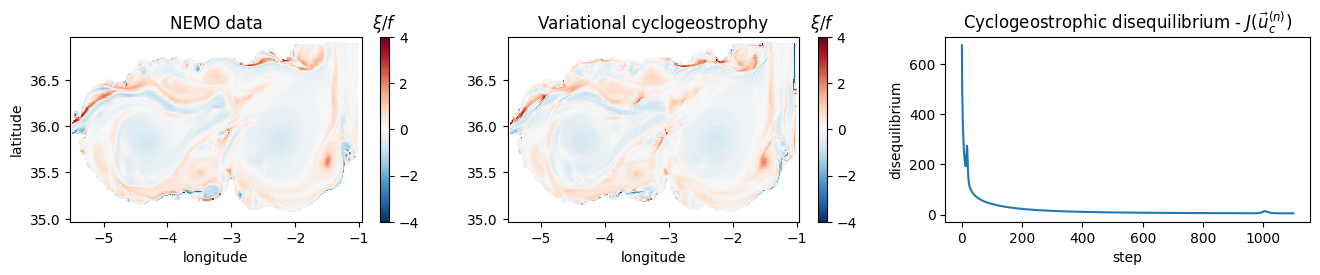

In [16]:
_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=get_figsize(1, 20/3))

ax1.set_title("NEMO data")
ax1.set_xlabel("longitude")
ax1.set_ylabel("latitude")
im = ax1.pcolormesh(lon, lat, norm_vorticity, cmap="RdBu_r", shading="auto", 
                    vmin=vmin, vmax=vmax)
clb1 = plt.colorbar(im, ax=ax1)
clb1.ax.set_title("$\\xi / f$")

ax2.set_title("Variational cyclogeostrophy")
ax2.set_xlabel("longitude")
im = ax2.pcolormesh(lon, lat, norm_vorticity_var, cmap="RdBu_r", shading="auto", 
                    vmin=vmin, vmax=vmax)
clb2 = plt.colorbar(im, ax=ax2)
clb2.ax.set_title("$\\xi / f$")

ax3.set_title("Cyclogeostrophic disequilibrium - $J(\\vec{u}_c^{(n)})$")
ax3.set_xlabel("step")
ax3.set_ylabel("disequilibrium")
ax3.plot(losses_var[:np.argmin(losses_var)+10])

plt.savefig("../paper/fig/variational.png", bbox_inches="tight")
plt.show()

### Iterative method

We use the same function, but with the argument `method="iterative"`. 

In [17]:
u_iterative, v_iterative, losses_it = cyclogeostrophy(u_geos, v_geos, dx_u, dx_v, dy_u, dy_v, coriolis_factor_u, coriolis_factor_v, 
                                                      method="iterative", return_losses=True)

u_iterative = ma.masked_array(u_iterative, mask_u)
v_iterative = ma.masked_array(v_iterative, mask_v)

norm_vorticity_iterative = compute_norm_vorticity(u_iterative, v_iterative, dy_u, dx_v, mask_ssh, coriolis_factor)

 20%|██        | 20/100 [00:00<00:00, 509.33it/s]


#### Comparison to NEMO's velocities

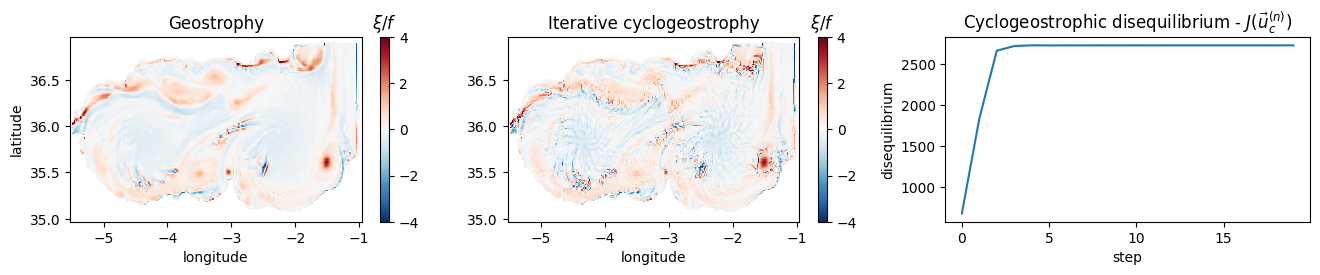

In [18]:
_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=get_figsize(1, 20/3))

ax1.set_title("Geostrophy")
ax1.set_xlabel("longitude")
ax1.set_ylabel("latitude")
im = ax1.pcolormesh(lon, lat, norm_vorticity_geos, cmap="RdBu_r", shading="auto", 
                    vmin=vmin, vmax=vmax)
clb1 = plt.colorbar(im, ax=ax1)
clb1.ax.set_title("$\\xi / f$")

ax2.set_title("Iterative cyclogeostrophy")
ax2.set_xlabel("longitude")
im = ax2.pcolormesh(lon, lat, norm_vorticity_iterative, cmap="RdBu_r", shading="auto", 
                    vmin=vmin, vmax=vmax)
clb2 = plt.colorbar(im, ax=ax2)
clb2.ax.set_title("$\\xi / f$")

ax3.set_title("Cyclogeostrophic disequilibrium - $J(\\vec{u}_c^{(n)})$")
ax3.set_xlabel("step")
ax3.set_ylabel("disequilibrium")
ax3.plot(losses_it)

plt.savefig("../paper/fig/iterative.png", bbox_inches="tight")
plt.show()

### Iterative method, with filter

We use the same function, but with the arguments `method="iterative"`, and `use_res_filter=True`. 

In [19]:
u_it_filter, v_it_filter, losse_it_filter = cyclogeostrophy(u_geos, v_geos, dx_u, dx_v, dy_u, dy_v, coriolis_factor_u, coriolis_factor_v, 
                                                             method="iterative", use_res_filter=True, return_losses=True)

u_it_filter = ma.masked_array(u_it_filter, mask_u)
v_it_filter = ma.masked_array(v_it_filter, mask_v)

norm_vorticity_it_filter = compute_norm_vorticity(u_it_filter, v_it_filter, dy_u, dx_v, mask_ssh, coriolis_factor)

100%|██████████| 100/100 [00:00<00:00, 420.93it/s]


#### Comparison to NEMO's currents

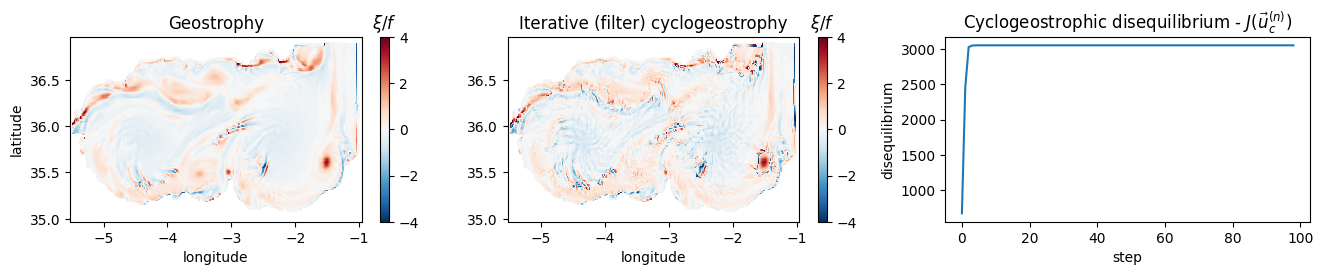

In [20]:
_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=get_figsize(1, 20/3))

ax1.set_title("Geostrophy")
ax1.set_xlabel("longitude")
ax1.set_ylabel("latitude")
im = ax1.pcolormesh(lon, lat, norm_vorticity_geos, cmap="RdBu_r", shading="auto", 
                    vmin=vmin, vmax=vmax)
clb1 = plt.colorbar(im, ax=ax1)
clb1.ax.set_title("$\\xi / f$")

ax2.set_title("Iterative (filter) cyclogeostrophy")
ax2.set_xlabel("longitude")
im = ax2.pcolormesh(lon, lat, norm_vorticity_it_filter, cmap="RdBu_r", shading="auto", 
                    vmin=vmin, vmax=vmax)
clb2 = plt.colorbar(im, ax=ax2)
clb2.ax.set_title("$\\xi / f$")

ax3.set_title("Cyclogeostrophic disequilibrium - $J(\\vec{u}_c^{(n)})$")
ax3.set_xlabel("step")
ax3.set_ylabel("disequilibrium")
ax3.plot(losse_it_filter)

plt.show()

## Overall quantitative comparison

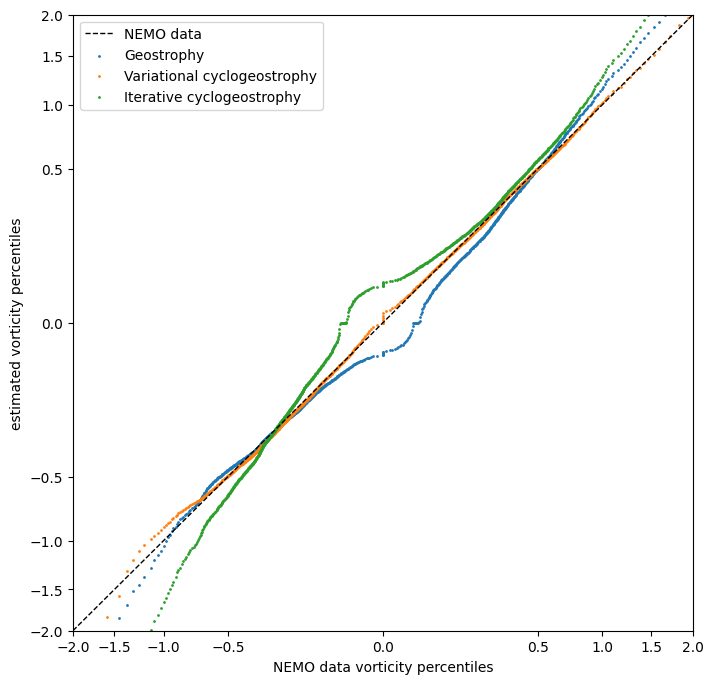

In [21]:
percentiles = np.linspace(0, 1, 1000)
vorticity_percentile = np.quantile(norm_vorticity.compressed(), percentiles)
vorticity_percentile_geos = np.quantile(norm_vorticity_geos.compressed(), percentiles)
vorticity_percentile_var = np.quantile(norm_vorticity_var.compressed(), percentiles)
vorticity_percentile_iterative = np.quantile(norm_vorticity_iterative.compressed(), percentiles)

fig = plt.figure(figsize=get_figsize(.5))
ax = fig.add_subplot(1, 1, 1)
ax.axline(xy1=(vorticity_percentile.min(), vorticity_percentile.min()), 
          xy2=(vorticity_percentile.max(), vorticity_percentile.max()), 
          linestyle="dashed", linewidth=1, color="black", label="NEMO data")
ax.scatter(vorticity_percentile, vorticity_percentile_geos, 
           s=1, label="Geostrophy")
ax.scatter(vorticity_percentile, vorticity_percentile_var, 
           s=1, label="Variational cyclogeostrophy")
ax.scatter(vorticity_percentile, vorticity_percentile_iterative, 
           s=1, label="Iterative cyclogeostrophy")
ax.legend()
ax.set_xlabel("NEMO data vorticity percentiles")
ax.set_ylabel("estimated vorticity percentiles")
ax.set_xscale('function', functions=(lambda x: np.sign(x) * np.sqrt(np.abs(x)), 
                                     lambda x: np.sign(x) * x**2))
ax.set_yscale('function', functions=(lambda x: np.sign(x) * np.sqrt(np.abs(x)), 
                                     lambda x: np.sign(x) * x**2))
ax.set_xlim((-2, 2))
ax.set_ylim((-2, 2))

plt.savefig("../paper/fig/qqplot.png", bbox_inches="tight")
plt.show()